# Proceso  de EDA para estudiar los datos, y preparacion para hacer un modelo de recomendacion

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split as train_test_splitSV
from sklearn.preprocessing import LabelEncoder
import pickle
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise import accuracy
from sklearn.metrics.pairwise import cosine_similarity


## Steam Games

In [ ]:
steam_games = pd.read_csv('./datasets/steam_games.csv')

In [10]:
steam_games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27834 entries, 0 to 27833
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   app_name                   27834 non-null  object 
 1   price                      27834 non-null  float64
 2   id                         27834 non-null  int64  
 3   developer                  27834 non-null  object 
 4   Accounting                 27834 non-null  int64  
 5   Action                     27834 non-null  int64  
 6   Adventure                  27834 non-null  int64  
 7   Animation &amp; Modeling   27834 non-null  int64  
 8   Audio Production           27834 non-null  int64  
 9   Casual                     27834 non-null  int64  
 10  Design &amp; Illustration  27834 non-null  int64  
 11  Early Access               27834 non-null  int64  
 12  Education                  27834 non-null  int64  
 13  Free to Play               27834 non-null  int

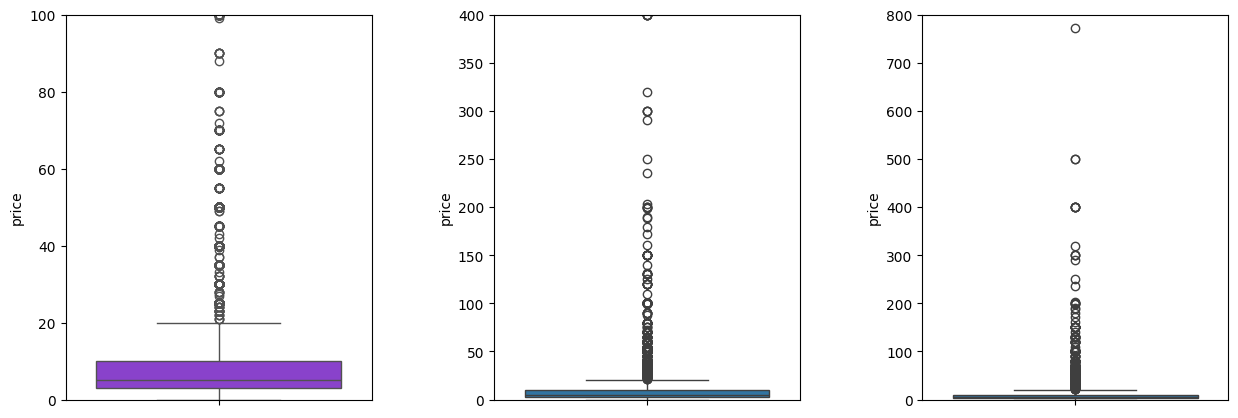

In [12]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.boxplot(data=steam_games,y='price',ax = ax[0],color='blueviolet')
sns.boxplot(data=steam_games,y='price',ax = ax[1])
sns.boxplot(data=steam_games,y='price',ax = ax[2])
ax[0].set_ylim(0,100)
ax[1].set_ylim(0,400)
ax[2].set_ylim(0,800)
plt.subplots_adjust(wspace=0.4)   # Agrego espacio entre los graficos
plt.show()

### En el grafico se puede ver que la columna price tiene muchos valores atipicos que superan los 20 y llegan a los 1000, sin embargo en una app de juegos es posible tener tal distribucion, es decir muchos juegos de precio bajo y varios de precio alto por esto no se hara un tratado especial

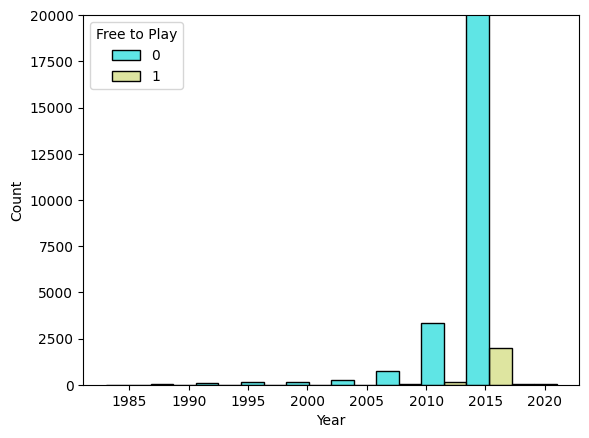

In [13]:
sns.histplot(data=steam_games,x='Year',hue='Free to Play',bins=10,palette='rainbow',multiple='dodge')

plt.ylim(0,20000)
plt.show()

### 2015 es el año con mas juegos y mas juegos Free To Play

## Users Reviews

In [14]:
user_review = pd.read_csv('./datasets/user_reviews.csv')

In [15]:
user_review.sample(5)

,user_id,posted,item_id,recommend,sentiment_analysis
4684,10051997,"Posted August 8, 2014.",236090,True,2
53088,ByanVEVO,"Posted June 22, 2014.",4000,False,0
31139,BurgerStab,"Posted October 31, 2015.",353270,True,1
30440,land-of-ramon,"Posted July 26, 2014.",570,True,2
47775,alpal88,"Posted December 5, 2015.",234190,True,2


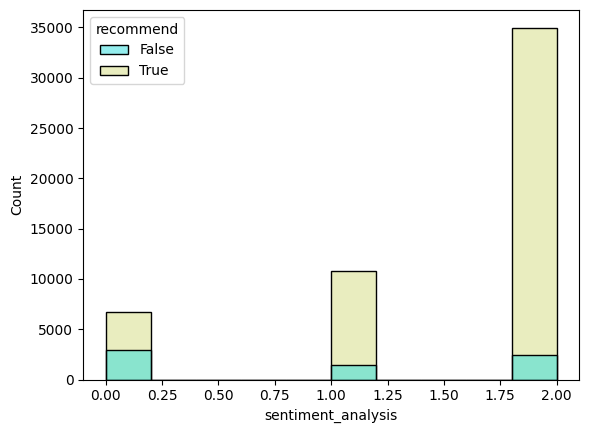

In [16]:
sns.histplot(data=user_review,x='sentiment_analysis',bins=10,palette='rainbow',hue='recommend')

plt.show()

### Como se ve del total de sentimiento malos, un alto porcentaje son recomendaciones falsas, y de los buenos el total de recomendaciones true son altas, Para ambas hay un porcentaje existente de recomendaciones que parecen opuesta al sentimiento

## Users Items

In [17]:
with gzip.open('datasets/user_items_proc.csv.gz', 'rb') as f:
    user_items_proc = pd.read_csv(f, encoding='utf-8')

In [18]:
user_items_proc.sample(5)

,user_id,items_count,steam_id,user_url,item_id,item_name,playtime_forever,playtime_2weeks
2623724,pearsonlikesdick,130,76561198044216541,http://steamcommunity.com/id/pearsonlikesdick,208580.0,STAR WARS‚Ñ¢ Knights of the Old Republic‚Ñ¢ II...,0.0,0.0
843150,76561198073910418,183,76561198073910418,http://steamcommunity.com/profiles/76561198073...,12230.0,Grand Theft Auto III,0.0,0.0
15558,Hirukaz,81,76561198061518530,http://steamcommunity.com/id/Hirukaz,4920.0,Natural Selection 2,220.0,0.0
5076511,smallbro,45,76561198098013837,http://steamcommunity.com/id/smallbro,218620.0,PAYDAY 2,262.0,0.0
1784528,wolvau,89,76561198054213560,http://steamcommunity.com/id/wolvau,13520.0,Far Cry,0.0,0.0


In [19]:
user_items_proc['item_id'].nunique()

10978

In [20]:
user_items_proc['playtime_forever'].describe()

count    5.153209e+06
mean     9.914951e+02
std      5.418204e+03
min      0.000000e+00
25%      0.000000e+00
50%      3.400000e+01
75%      3.550000e+02
max      6.427730e+05
Name: playtime_forever, dtype: float64

In [21]:
user_items_proc['playtime_forever'].idxmax()
id = user_items_proc.iloc[587715]['item_id']
steam_games[steam_games['id'] == id]['Year']


38    2006.0
Name: Year, dtype: float64

<Axes: ylabel='playtime_forever'>

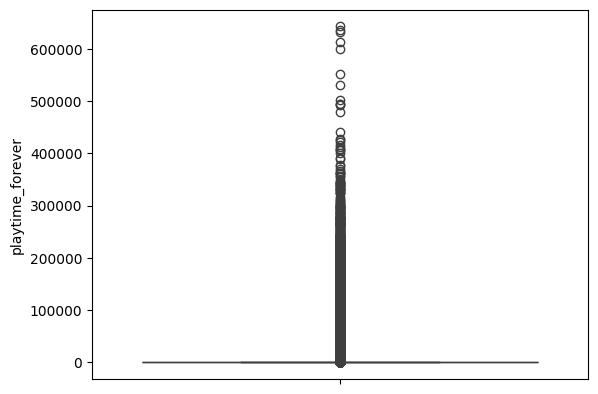

In [22]:
sns.boxplot(data=user_items_proc,y='playtime_forever')


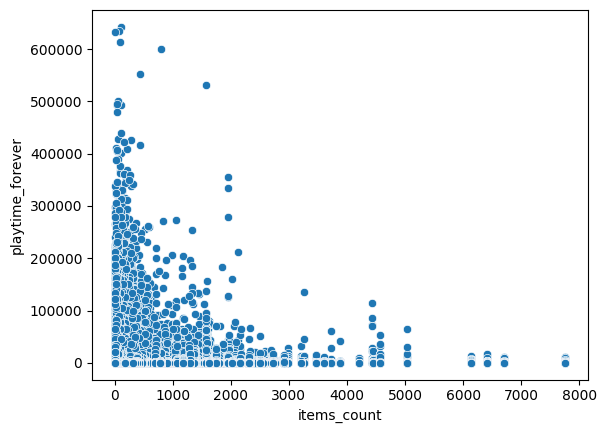

In [23]:
sns.scatterplot(data=user_items_proc,x='items_count',y='playtime_forever')
plt.show()

### Se podria analisar de forma que a menos cantidad de items mas tiempo consume un usuario un juego especifico.

# Modelo de recomendacion

### Cargo el dataset usado para el modelo

In [46]:
user_reviews = pd.read_csv('./datasets/user_reviews.csv',usecols=['user_id','item_id','sentiment_analysis','recommend'])
label_encoder = LabelEncoder()
#elimino la columna user_id
user_reviews['user_id_num'] = label_encoder.fit_transform(user_reviews['user_id'])



### Voy a generar un rating a partir de recommend y sentiment_analysis para que este entre 0 y 5

In [47]:
"""for index, row in user_reviews.iterrows():
    if (row[2] == 1) and (row[3] == 2):
        user_reviews.at[index, 'rating'] = 3
    elif (row[2] == 1) and (row[3] == 1):
        user_reviews.at[index, 'rating'] = 2
    elif (row[2] == 1) and (row[3] == 0):
        user_reviews.at[index, 'rating'] = 1
    elif (row[2] == 0) and (row[3] == 2):
        user_reviews.at[index, 'rating'] = 2
    elif (row[2] == 0) and (row[3] == 1):
        user_reviews.at[index, 'rating'] = 1
    elif (row[2] == 0) and (row[3] == 0):
        user_reviews.at[index, 'rating'] = 0"""

"for index, row in user_reviews.iterrows():\n    if (row[2] == 1) and (row[3] == 2):\n        user_reviews.at[index, 'rating'] = 3\n    elif (row[2] == 1) and (row[3] == 1):\n        user_reviews.at[index, 'rating'] = 2\n    elif (row[2] == 1) and (row[3] == 0):\n        user_reviews.at[index, 'rating'] = 1\n    elif (row[2] == 0) and (row[3] == 2):\n        user_reviews.at[index, 'rating'] = 2\n    elif (row[2] == 0) and (row[3] == 1):\n        user_reviews.at[index, 'rating'] = 1\n    elif (row[2] == 0) and (row[3] == 0):\n        user_reviews.at[index, 'rating'] = 0"

In [48]:
user_reviews['rating'] = np.where(user_reviews['recommend'] == True,  # Si 'recommend' es True
                                 np.where(user_reviews['sentiment_analysis'] == 2, 5,  # Si 'sentimiento' es positivo
                                          np.where(user_reviews['sentiment_analysis'] == 1, 3,  # Si 'sentimiento' es neutro
                                                   1)),  # Si 'sentimiento' es negativo cuando 'recommend' es True
                                 np.where(user_reviews['sentiment_analysis'] == 2, 4,  # Si 'sentimiento' es positivo
                                          np.where(user_reviews['sentiment_analysis'] == 1, 2,  # Si 'sentimiento' es neutro
                                                   0)))  # Si 'sentimiento' es negativo cuando 'recommend' es False

In [49]:
user_reviews.sample(5)

,user_id,item_id,recommend,sentiment_analysis,user_id_num,rating
50605,76561198063055125,239070,True,2,5348,5
53520,76561198076114293,17460,True,2,7647,5
46727,newhollandarmy,223470,True,1,22668,3
46078,76561198024028497,227100,False,0,1647,0
53714,TheMarshmallowMan101,730,True,2,17361,5


In [50]:
print(user_reviews['rating'].max())
print(user_reviews['rating'].min())

5
0


### Genero id numericos para user_id usando label encoder

In [51]:
reader = Reader(rating_scale=(0,5))
data = Dataset.load_from_df(user_reviews[['user_id_num','item_id','rating']], reader)


### Separo el dataset en entrenamiento y testeo

In [52]:
train,test = train_test_splitSV(data,test_size = .25)

## Voy a usar un modelo De descomposicion en valor singular (SVD), el cual es un filtro colaborativo
### Voy a usar los datos de 
* user_id
* item_id
* sentiment_analysis: como rating

### Aplico GridSearch para encontrar al modelo con los mejores hiperparametros

In [53]:
param_grid = {'n_factors': [5,50,100],'n_epochs': [5, 10,20], 'lr_all': [0.001, 0.002, 0.005],
              'reg_all': [0.002, 0.02, 0.2]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs = -1)
gs.fit(data)


In [54]:
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])
best_model = gs.best_estimator['rmse']

1.5840100111706839
{'n_factors': 100, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.2}


### Veo que el modelo tiene un rmse de 1.06 lo cual esta cerca de 1lo cual en la escala esta bien
### Ademas veo los mejores hiperparametros

## Por ultimo defino el modelo con los mejores hiperparametros y lo exporto

In [55]:
model = SVD(n_factors=100,n_epochs=20,lr_all=0.005,reg_all=0.2)
model.fit(train)

In [56]:
from surprise import accuracy
train_predictions = model.test(train.build_testset())
test_predictions = model.test(test)
print(f"RMSE en el conjunto de entrenamiento: {accuracy.rmse(train_predictions)}")
print(f"RMSE en el conjunto de prueba: {accuracy.rmse(test_predictions)}")

RMSE: 1.2764
RMSE en el conjunto de entrenamiento: 1.2764039278981176
RMSE: 1.5817
RMSE en el conjunto de prueba: 1.5817043122021668


### EL modelo obtuvo un mejor rendimiento en los datos de testeo el rmse 1.5 me indica que en en el ranking de 0 5 lo que indica una desviacion de 1.5 si bien tiene mucho rango de mejora para las columnas usadas como rating esta bastante bien

In [57]:
with open('./model/SVD_model.pkl', 'wb') as file: # Exporto mi modelo
    pickle.dump(model, file)

In [58]:
print(model.predict(4124,12354))
print(model.predict(4124,1244))
print(model.predict(4124,154))
print(model.predict(4124,12554))
print(model.predict(4124,1213))
print(model.predict(4124,1884))
print(model.predict(4124,35354))
print(model.predict(4124,1324))
print(model.predict(4124,13224))


user: 4124       item: 12354      r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 1244       r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 154        r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 12554      r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 1213       r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 1884       r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 35354      r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 1324       r_ui = None   est = 3.82   {'was_impossible': False}
user: 4124       item: 13224      r_ui = None   est = 3.82   {'was_impossible': False}


## A contuacion hare un modelo basado en 
* Para esto usare la tabla steam_games y los generos de los juegos

In [92]:
def item_rec(app_name:int):
    generos = list(steam_games.drop(columns=['app_name','price','id','developer','Accounting','Year']).columns)
    generos
    perfiles_items = []
    for _, row in steam_games.iterrows():
        perfil_item = []
        for genero in generos:
            perfil_item.append(row[genero])
        perfiles_items.append(perfil_item)

    perfiles_items_df = pd.DataFrame(perfiles_items, columns=generos)
    perfiles_items_df['app_name'] = steam_games['app_name']
    perfiles_items_df['id'] = steam_games['id']

    # Nombre de la aplicación para la cual deseas obtener recomendaciones
    if app_name not in list(steam_games['id']):
        return 'EL item no se a podido encontrar'

    # Encuentra el índice correspondiente al nombre de la aplicación
    app_index = perfiles_items_df[perfiles_items_df['id'] == app_name].index[0]
    perfiles_items_array = perfiles_items_df.drop(columns=['app_name','id']).values
    # Obtén el perfil de la aplicación del DataFrame
    app_profile = perfiles_items_array[app_index].reshape(1, -1)

    # Calcula la similitud de coseno entre el perfil de la aplicación y todos los perfiles de items
    similarity_scores = cosine_similarity(app_profile, perfiles_items_array)

    # Ordena los juegos por similitud y toma los primeros 5 juegos recomendados
    recommended_games = np.argsort(similarity_scores[0])[::-1][:5]

    # Obtiene los índices de los juegos recomendados en el DataFrame original
    recommended_game_indices = perfiles_items_df.index[recommended_games]

    # Obtiene los nombres de los juegos recomendados
    recommended_game_names = perfiles_items_df.loc[recommended_game_indices, 'app_name']
    return {
        'Recomendacion 1':recommended_game_names.iloc[0],
        'Recomendacion 2':recommended_game_names.iloc[1],
        'Recomendacion 3':recommended_game_names.iloc[2],
        'Recomendacion 4':recommended_game_names.iloc[3],
        'Recomendacion 5':recommended_game_names.iloc[4]
            }


In [93]:
item_rec(658870)

{'Recomendacion 1': 'EXIT 2 - Directions',
 'Recomendacion 2': 'Keep Rollin!',
 'Recomendacion 3': 'Tetropunk',
 'Recomendacion 4': "Alexa's Wild Night",
 'Recomendacion 5': 'Zup! 7 - 4:3 Pack'}